In [0]:
from __future__ import division
import numpy as np
from scipy.optimize import root, fsolve, broyden1
from functools import partial
import pandas as pd
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
%matplotlib inline  



In [0]:
#defined for 2d use
def Dx(u,h):
  s = np.zeros(u.shape)
  for i in range(len(u[0,0,:])):
    uu = u[:,:,i]
    uudx=np.diff(np.column_stack((uu,uu[:,0])))/h
    s[:,:,i] = uudx
  return s

def Dy(u,h):
  s = np.zeros(u.shape)
  for i in range(len(u[0,0,:])):
    uu = u[:,:,i]
    uudx=np.diff(np.vstack((uu,uu[0])),axis=0)/h
    s[:,:,i] = uudx
  return s

def dx(u,h):
  s = np.zeros(u.shape)
  for i in range(len(u[0,0,:])):
    uu = u[:,:,i]
    uudx = np.diff(np.column_stack((uu[:,-1],uu)))/h
    s[:,:,i] = uudx
  return s

def dy(u,h):
  s = np.zeros(u.shape)
  for i in range(len(u[0,0,:])):
    uu = u[:,:,i]
    uudx = np.diff(np.vstack((uu[-1],uu)),axis=0)/h
    s[:,:,i] = uudx
  return s

def Dh(u,h):
  return np.array([Dx(u,h),Dy(u,h)])

def dh(f,h):
  return dx(f[0],h) + dy(f[1],h)

# def Dx(u,h):
# 	return np.diff(np.column_stack((u,u[:,0])))/h
# def Dy(u,h):
# 	return np.diff(np.vstack((u,u[0])),axis=0)/h
# def dx(u,h):	return np.diff(np.column_stack((u[:,-1],u)))/h
# def dy(u,h):
# 	return np.diff(np.vstack((u[-1],u)),axis=0)/h
# def Dh(u,h):
# 	return np.array([Dx(u,h),Dy(u,h)])
# def dh(f,h):
# 	return dx(f[0],h) + dy(f[1],h)


The data structure of u is 

$u=[u_i^{kl}]$

$i:$ i-th component
$k,l$ the $k,l$-th value

In [0]:
u=np.array([[[1,2,3],[1,2,3]],[[1,2,3],[1,2,3]]])
dx(u,1)

array([[[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]])

In [0]:
dh(Dh(u,1),1)

array([[[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]])

In [0]:
uu=np.array([[1,2],[3,4]])
np.diff(np.column_stack((uu,uu[:,0])))
for uu in u:
  for mm in uu:
    print(mm)

[1 2 3]
[1 2 3]
[1 2 3]
[1 2 3]


In [0]:
class MSsolver2d():
  def __init__(self,h,k,sp,bm,scope,uinitial, steps = 100000, savesteps=1):
    self.h = h
    self.k = k
    self.sp = sp
    self.x = np.linspace(scope[0,0],scope[0,1],(scope[0,1]-scope[0,0])/h+1)
    self.y = np.linspace(scope[1,0],scope[1,1],(scope[1,1]-scope[1,0])/h+1)
    self.gridpt = np.meshgrid(self.x,self.y)
    self.u0 = np.array([[uinitial([x,y]) for x in self.x] for y in self.y])
    self.u = self.u0
    self.uold = self.u0
    self.steps = steps
    if type(savesteps) == int:
      self.savesteps = range(0,steps,savesteps)
    else:
      self.savesteps = savesteps
    self.bm=bm
    # self.bm = np.full((sp,sp),1)
    # self.bm =self.bm- np.identity(sp)
    self.usol = [self.uold]
    self.tt=[0]
  def Bmatrix(self,u):
    Bmt = []
    for ss in u:
      Bmtt = []
      for uu in ss:
        s = np.zeros([len(uu),len(uu)])
        for i in range(len(uu)):
          for j in range(len(uu)):
            s[i,j] = self.bm[i,j]*uu[i]*uu[j]
            # s[i,j] = self.bm[i,j]
        # for i in range(len(uu)):
          # s[i,i] = np.sum(s[:,i])
        ss = np.sum(s,axis=0)
        tau_d = np.diag(ss) - s 
        tau = tau_d[:-1,:-1]
        Q = np.diag(1/uu) + 1/uu[-1]
        Q = Q[:-1,:-1]
        #SS = Q.dot(tau).dot(Q) #for testing
        SS=np.linalg.inv(Q).dot(np.linalg.inv(tau)).dot(np.linalg.inv(Q))
        # SS=np.array([[uu[0]*(1-uu[0]),-uu[0]*uu[1]],[-uu[0]*uu[1],uu[1]*(1-uu[1])]])
        Bmtt.append(SS)
      Bmt.append(Bmtt)
    return np.array(Bmt)
  def Nsh(self,uold):
    # dd=[]
    Dhu = Dh(np.log(self.u),self.h)
    #Dhu = Dh(np.exp(self.u),self.h) #for testing
    dd = np.zeros(Dhu.shape)
    for i in range(len(Dhu[0,0,0,:])-1):
      dd[:,:,:,i]=Dhu[:,:,:,i]-Dhu[:,:,:,-1]
    
    # for i in range(self.sp-1):
      # dd.append(Dh(np.log(self.u[:,:,i])-np.log(self.u[:,:,-1]),self.h))
      # dd.append(Df(self.u[:,i],self.h)/self.u[:,i] - Df(self.u[:,-1],self.h)/self.u[:,-1])
    # dd = np.array(dd)
    Bmt = self.Bmatrix(uold)
    rhov = np.zeros([dd.shape[0],len(Bmt),len(Bmt[0]),dd.shape[-1]])
    for ss in range(dd.shape[0]):
      for j in range(len(Bmt)):
        for k in range(len(Bmt[j])):
          rhov[ss,j,k,:-1]=(Bmt[j,k].dot(dd[ss,j,k,:-1]))
          rhov[ss,j,k,-1] = - np.sum(rhov[ss,j,k,:-1]) 
    rhov = np.array(rhov)
    f = dh(rhov,self.h)
    # f = np.append(f,-np.array([np.sum(f,axis=1)]).T,axis=1)
    return f
  def forward_diff(self):
    self.uold = self.u
    self.u = self.u + self.k*self.Nsh(self.uold)
  def implicit(self):
    g = lambda u:(u - self.uold) - self.k* self.Nsh(self.u)
    sol=root(g,self.uold,method='df-sane')
    self.u=sol.x
    self.u = self.u + self.k*self.Nsh(self.u)
  def explicit_implicit(self):
    self.uold = self.u
    g = lambda u:(u - self.uold) - self.k* self.Nsh(self.uold)
    sol=root(g,self.uold,method='df-sane')
    self.u=sol.x
  def run(self,method='forward_diff'):
    self.method = method
    for i in range(self.steps+1):
      if method == 'forward_diff':
        self.forward_diff()	
      elif method == 'explicit_implicit':
        self.explicit_implicit()
      elif method == 'implicit':
        self.implicit()
      else:
        raise Exception('Method not defined!')
      if i in self.savesteps:
        self.usol.append(self.u)
        self.tt.append(self.k*i)
    self.usol = np.array(self.usol)


In [0]:

scope = np.array([[0,1],[0,1]])
def uinitial(x):
  y = np.array(((0.8*(x[0]<0.25)+1.6*(0.75-x[0])*(x[0]>=0.25)*(x[0]<0.75)+0.0001*(x[0]>=0.75),0.20*(x[0]>-1)-0.0001)))
  #y = np.array(((0.8*(x[0]<0.25)*(x[1]<0.25)+1.6*(0.75-x[1])*(x[0]>=0.25)*(x[0]<0.75)*(x[1]>=0.25)*(x[1]<0.75)+0.0001*(x[1]>=0.75),0.20*(x[0]>-1)*(x[1]>-1)-0.0001)))
  yy = 1 - y[0]-y[1]
  return np.append(y,yy)

d12 = 1/0.833
d13 = 1/0.833
d23 = 1/0.168
bm=np.array([[0,d12,d13],[d12,0,d23],[d12,d23,0]])
# a = MSsolver(0.01,0.00001,3,bm,scope,uinitial)
a = MSsolver2d(0.05,0.0001,3,bm,scope,uinitial,5000)
#a.run('forward_diff')
a.run('explicit_implicit')
# a.Nsh(a.u)

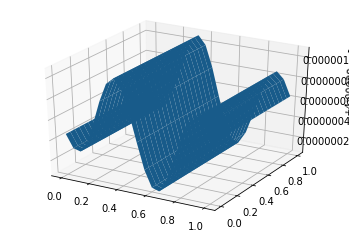

In [0]:
X = np.linspace(scope[0,0],scope[0,1],(scope[0,1]-scope[0,0])/0.05+1)
Y = np.linspace(scope[0,0],scope[0,1],(scope[0,1]-scope[0,0])/0.05+1)
[X,Y] = np.meshgrid(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, a.usol[-1,:,:,0])
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.07f'))


(0, 0.8)

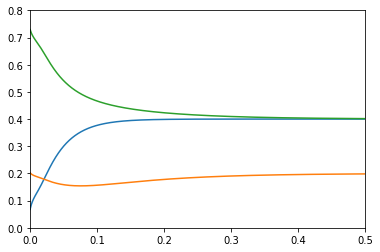

In [0]:
plt.plot(a.usol[:,14,14,:])


(-2e-13, 2e-13)

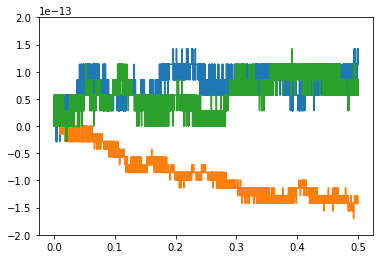

In [0]:
ss=[[np.sum(a.usol[i,:,:,j])-np.sum(a.usol[0,:,:,j]) for i in range(a.usol.shape[0])] for j in range(a.usol.shape[-1])]
plt.plot(a.tt,np.transpose(ss))
axes = plt.gca()
axes.set_ylim([-2e-13,2e-13])
